In [7]:
import numpy as np 
import pandas as pd
import os, re, pickle,pathlib
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Dense, Bidirectional, Dropout, BatchNormalization

In [8]:
seed = 42
val_size = 0.15
test_size = 0.15

data_dir = 'data/'

In [9]:
def load_data():
    df_final = None
    
    projects = os.listdir(data_dir)
    for project in projects:
        project_dir = os.path.join(data_dir, project)
        priority_files = os.listdir(project_dir)
        for priority_file in priority_files:
            priority_file_path = os.path.join(project_dir, priority_file)
            df_pi = pd.read_csv(priority_file_path)
            if (df_final is None):
                df_final = df_pi
                
            else:
                df_final = pd.concat([df_final, df_pi])
                
    return df_final


df = load_data()
df = df[['Product', 'Component', 'Summary', 'Priority']]
df

,Product,Component,Summary,Priority
0,z_Archived,TPTP,NoSuchMethodError when starting the org.eclips...,P1
1,MDT,Releng,New & Noteworthy,P1
2,z_Archived,TPTP,org.eclipse.tptp.platform.rcp.common plugin mi...,P1
3,Community,Infrastructure,Capella HIPP cannot clone repositories,P1
4,z_Archived,TPTP,Apache Tomcat profiling crashes with Thread An...,P1
...,...,...,...,...
2473,java,Editor,[Override Methods] Overrided methods can suppo...,P4
2474,utilities,Properties,Missing ability to mark more properties for de...,P4
2475,obsolete,vcscvs,RFE:CVS-Add Recursively ....(had problem with ...,P4
2476,guibuilder,Code,Suggested Connection Wizard enhancements: JPop...,P4


In [10]:
class_dict = {
            'P1' : 0,
            'P2' : 1,
            'P3' : 2,
            'P4' : 3,
            'P5' : 4
                }
df['Priority'] = df['Priority'].apply(lambda x: class_dict[x])

In [11]:
Summaries = df['Summary'].values
Priorities = df['Priority'].values

Summaries, Priorities = shuffle(Summaries, Priorities)

X, Xtest, Y, Ytest = train_test_split(
                                    Summaries, Priorities, 
                                    test_size = test_size, 
                                    random_state = seed)

In [12]:
class_weights = compute_class_weight(
                                'balanced',
                                 classes = np.unique(Y),
                                 y = Y)

'''

Eqn : Total Number of Samples / (2 * Number of Samples in Given Class)

'''
class_weights = {i : class_weights[i] for i in range(len(set(Y)))}
class_weights

{0: 1.6399037635332532,
 1: 0.8009568574785966,
 2: 0.6258263378803778,
 3: 1.4822305063684373,
 4: 1.1505425608873885}

In [13]:
def preprocess_one(x):
    '''
        Text preprocess on term text using above functions
    '''
    stopwords_list = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'\w+')
        
    try:
        x = x.lower()
        x = tokenizer.tokenize(x) # Remove puntuations & Tokenization
        x = [token for token in x if token not in stopwords_list]
        x = [re.sub('[0-9]', '', i) for i in x] # Remove Numbers
        x = [i for i in x if len(i)>0] # Remove empty strings
        x = [lemmatizer.lemmatize(k) for k in x] # Word Lemmatization
        x = ' '.join(x)
        
    except:
        x = ''
        
    x = x.strip()
    return x

In [14]:
def preprocessed_data(X):
    X = [preprocess_one(x) for x in X]
    return X

X = preprocessed_data(X)
Xtest = preprocessed_data(Xtest)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectorizer.fit(X)

TfidfVectorizer()

In [16]:
X_seq = vectorizer.transform(X)
Xtest_seq = vectorizer.transform(Xtest)

In [18]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=5000)
svd.fit(X_seq)
var_explained = svd.explained_variance_ratio_.sum()
var_explained

0.8410025026017043

In [19]:
X_seq = svd.transform(X_seq)
Xtest_seq = svd.transform(Xtest_seq)

In [20]:
# SVM model

from sklearn.svm import SVC

classifier = SVC(
                kernel = 'linear',
                class_weight = class_weights
                )
classifier.fit(X_seq, Y)

SVC(class_weight={0: 1.6399037635332532, 1: 0.8009568574785966,
                  2: 0.6258263378803778, 3: 1.4822305063684373,
                  4: 1.1505425608873885},
    kernel='linear')

In [24]:
target_names = ['P1', 'P2', 'P3', 'P4', 'P5']
Ptest = classifier.predict(Xtest_seq)
Ytest_ = Ytest

In [25]:
# Classification Report
from sklearn.metrics import classification_report

print(classification_report(
                            Ytest_, 
                            Ptest, 
                            target_names=target_names
                            ))

              precision    recall  f1-score   support

          P1       0.43      0.60      0.50      1080
          P2       0.46      0.41      0.44      2185
          P3       0.61      0.54      0.57      2516
          P4       0.45      0.50      0.48      1147
          P5       0.68      0.67      0.68      1493

    accuracy                           0.53      8421
   macro avg       0.53      0.55      0.53      8421
weighted avg       0.54      0.53      0.53      8421



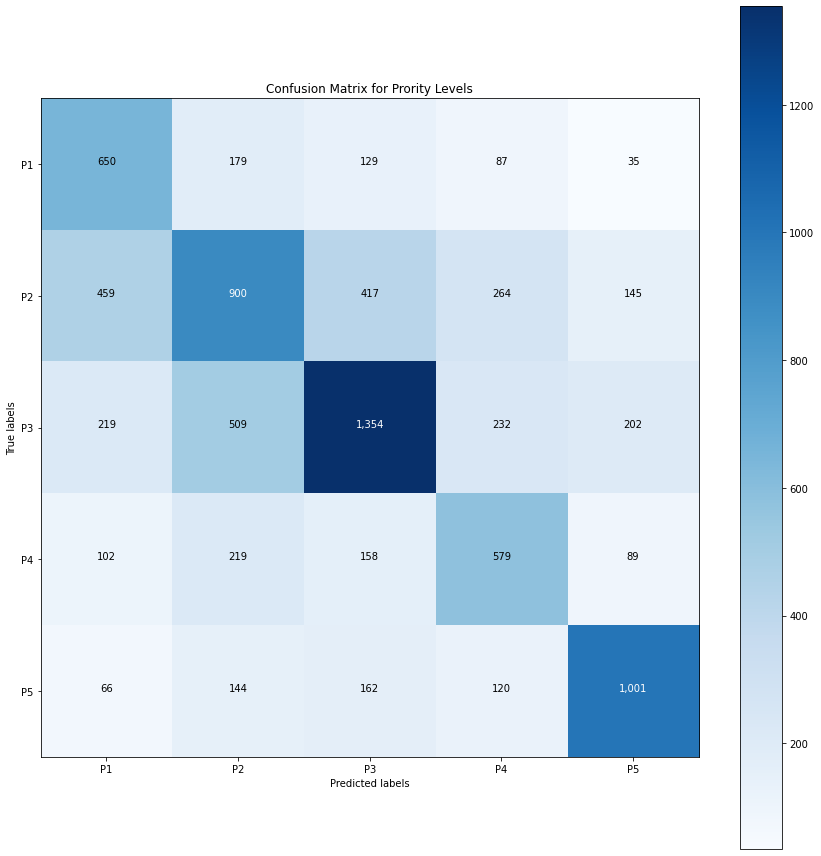

In [26]:
# Confusion Matrix 
import itertools
from sklearn.metrics import confusion_matrix

cmap, normalize = None, False
cm = confusion_matrix(Ytest_, Ptest)

if cmap is None:
    cmap = plt.get_cmap('Blues')

plt.figure(figsize=(12, 12))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion Matrix for Prority Levels')
plt.colorbar()

tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=0)
plt.yticks(tick_marks, target_names)

if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


thresh = cm.max() / 1.5 if normalize else cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if normalize:
        plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    else:
        plt.text(j, i, "{:,}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")


plt.tight_layout()
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

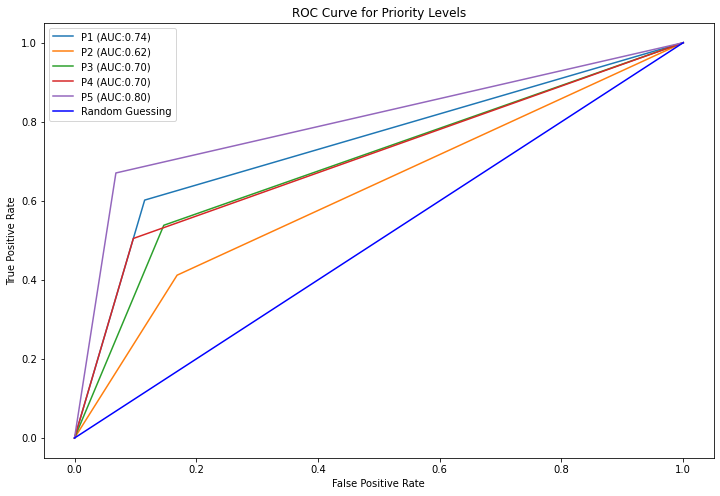

In [27]:
# ROC Curve
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

lb = LabelBinarizer()
lb.fit(Ytest_)
Ytest_ = lb.transform(Ytest_)
Ptest = lb.transform(Ptest)

for (idx, c_label) in enumerate(target_names):
    fpr, tpr, thresholds = roc_curve(Ytest_[:,idx].astype(int), Ptest[:,idx])

    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
c_ax.set_title('ROC Curve for Priority Levels')
plt.show()